# Сегментация пользователей "Метанпромбанк" по потреблению

Описание проекта: Сегментация пользователей по количеству потребляемых продуктов, выявить какие пользователи наиболее склоны отказаться от услуг банка.

Цель: снижение уровня оттока пользователей "Метанпромбанк" 

План проекта:
1. Выгрузка и ознакомление с общей информацией о данных
2. Предобработка данных
- Проверка на явные дубликаты и пропуски
- Стиль названий столбцов
- Проверка данных на выбросы
3. Исследовательский анализ данных
- Распределение клиентов банка по признакам
- Матрица корреляций
4. Сегментация пользователей
- Портрет клиента, использующего 1 продукт
- Портрет клиента, использующего 2 продукта
- Портрет клиента, использующего 3 продукта
- Портрет клиента, использующего 4 продукта

5. Статистический анализ данных
- 1 гипотеза: Средняя зарплата клиентов, использующих один продукт, не отличается от средней зарплаты клиентов использующих 2 продукта.
- 2 гипотеза: Доля ушедших пользователей, использующих кредитную карту, не отличается от доли ушедших пользователей, не использующих кредитную карту. 

6. Общие выводы, рекомендации

Ссылка на презентацию:
https://disk.yandex.ru/i/MVp3U0Gd_Pn14w

## Выгрузка и ознакомление с общей информацией о данных

In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats as st
import numpy as np
import math as mth

In [165]:
try:
    banks = pd.read_csv('bank_dataset.csv')
except:
    banks = pd.read_csv('https://code.s3.yandex.net/datasets/bank_dataset.csv')

Выведем первые 10 строк таблицы

In [166]:
banks.head(10)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


Рассмотрим основную информацию о датасете

In [167]:
banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Можно заметить, что столбцы churn,CreditCard и Loyalty , где значения принадлежат 1 и 0 имеют тип int. Для таких столбцов тип данных можно заменить на bool. Также можно привести названия столбцов к нижнему регистру.

## Предобработка данных

### Стиль столбцов

Приведем названия столбцов к нижнему регистру

In [168]:
banks.columns = banks.columns.str.lower() #приведем названия столбцов к нижнему регистру

Переименуем столбец userid

In [169]:
banks = banks.rename(columns={'userid' : 'user_id', 'creditcard' : 'credit_card'})

Заменим тип данных в столбцах churn,credit_card и loyalty на bool, user_id на object

In [170]:
banks['churn'] = banks['churn'].astype('bool')
banks['credit_card'] = banks['credit_card'].astype('bool')
banks['loyalty'] = banks['loyalty'].astype('bool')
banks['user_id'] = banks['user_id'].astype('str')

### Проверка на явные дубликаты и пропуски

Проверим на наличие явных дубликатов

In [171]:
banks.duplicated().sum() #поиск строк явных дубликатов

0

Проверим на количество пропусков в каждом столбце

In [172]:
banks.isna().sum() #к-во пропусков в каждом столбце

user_id                0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

Можно заметить что пропуски присутствуют только в столбце balance (3617), однако их слишком много и их характер пока непонятен.

Посмотрим строки с пропусками в столбце balance

In [173]:
banks[banks['balance'].isna()]

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,True,True,101348.88,True
3,15744090,699,Ярославль,Ж,39,1,NaN,2,False,False,93826.63,False
6,15635267,822,Ярославль,М,50,7,NaN,2,True,True,10062.80,False
11,15779909,497,Рыбинск,М,24,3,NaN,2,True,False,76390.01,False
12,15675000,476,Ярославль,Ж,34,10,NaN,2,True,False,26260.98,False
...,...,...,...,...,...,...,...,...,...,...,...,...
9989,15648358,841,Рыбинск,М,28,4,NaN,2,True,True,179436.60,False
9992,15699841,726,Рыбинск,М,36,2,NaN,1,True,False,195192.40,False
9994,15762030,800,Ярославль,Ж,29,2,NaN,2,False,False,167773.55,False
9995,15648965,771,Ярославль,М,39,5,NaN,2,True,False,96270.64,False


На первый взгляд ничего необычного и общего в этих строках нет.

In [174]:
columns = ['city', 'gender', 'objects', 'products', 'credit_card', 'loyalty', 'churn']
for i in columns:
    abc = banks.groupby(i)['balance'].apply(lambda x: x.isna().sum())
    display(abc)

city
Ростов Великий       0
Рыбинск           1199
Ярославль         2418
Name: balance, dtype: int64

gender
Ж    1654
М    1963
Name: balance, dtype: int64

objects
0     137
1     349
2     382
3     352
4     369
5     374
6     367
7     386
8     363
9     360
10    178
Name: balance, dtype: int64

products
1     905
2    2600
3      98
4      14
Name: balance, dtype: int64

credit_card
False    1025
True     2592
Name: balance, dtype: int64

loyalty
False    1744
True     1873
Name: balance, dtype: int64

churn
False    3117
True      500
Name: balance, dtype: int64

Рассмотрим, есть ли пользователи с отрицательным балансом.

In [175]:
banks.query('balance <= 0').count()

user_id             0
score               0
city                0
gender              0
age                 0
objects             0
balance             0
products            0
credit_card         0
loyalty             0
estimated_salary    0
churn               0
dtype: int64

Можно заметить, что огромно количество пропусков преобладает для клиентов, использующих 2 продукта, а также использующих кредитную карту. Также 86% пропусков в балансе составляют оставшиеся клиенты, поэтому пропуски нельзя связать с уходом клиентов и закрытием счетов. Возможно, пользователи имеют 2 продукта: дебетовая и кредитная карта. Из-за процентов или несвоевременного закрытия кредитной карты общий баланс счета становится отрицательным, поэтому вместо баланса появляются пропуски. 
Поскольку клиентов с балансом меньше 0 не удалось найти в датасете, то скорее всего причина именно в этом.

### Проверим данные на выбросы

Рассмотрим столбец с зарплатой

<AxesSubplot:>

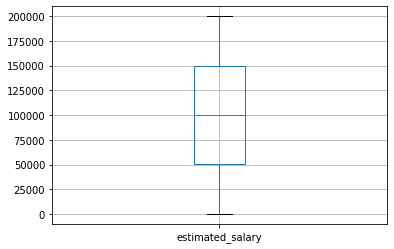

In [176]:
banks.boxplot(column='estimated_salary')

Рассмотрим столбец с баллами пользователя

<AxesSubplot:>

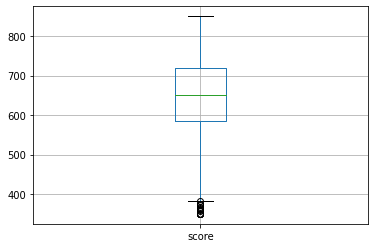

In [177]:
banks.boxplot(column='score')

 Можно сказать что меньше 380 баллов кредитного скоринга являются скорее аномальными значениями

<AxesSubplot:>

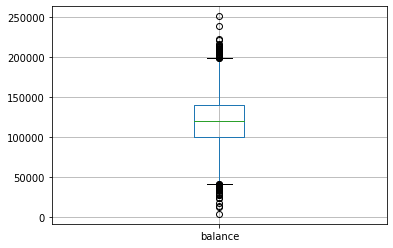

In [178]:
banks.boxplot(column='balance')

Для баланса на карте аномальными значениями можно назвать значения выше 220000 рублей.

Аномалий, которые могут значительно повлиять на исследования как таковых нет, поэтому удалять их не будем.

Вывод: в ходе предобработки данных удалось выяснить, что явных дубликатов в данных нет. Все столбцы были приведены к нижнему регистру, названия столбцов user_id и credit_card были изменены. Для столбцов hurn,credit_card и loyalty тип данных был изменен на bool, для столбца user_id на object. Было обнаружено большое количество пропусков в столбце balance, однако они занимают слишком большой процент от общего числа данных для того, чтобы их удалять. Поэтому принято решение оставить их. Причиной появления пропусков предположительно является несвоевременное закрытие кредитной карты, а следовательно появление отрицательного баланса, который отображается как nan. Была проведена проверка на аномалии: Для баланса на карте аномальными значениями можно назвать значения выше 220000 рублей,также меньше 380 баллов кредитного скоринга являются скорее аномальными значениями. 

## Исследовательский анализ данных

Посчитаем общее количество клиентов банка

In [179]:
banks['user_id'].nunique() 

10000

### Распределение клиентов банка по признакам


Для того, чтобы не строить каждый график в отдельности напишем цикл, который выведет графики в соответствии с выбранными категориями.

Рассмотрим распределение клиентов по категориям 'balance', 'score', 'estimated_salary', 'age' в виде гистограм

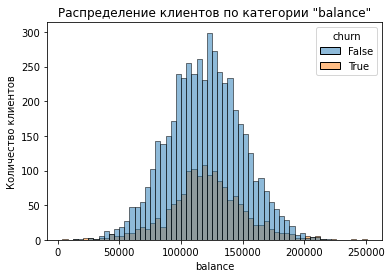

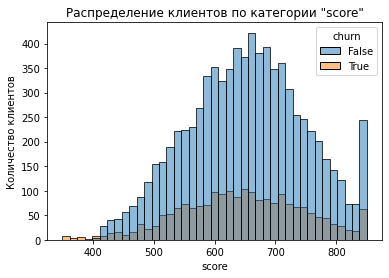

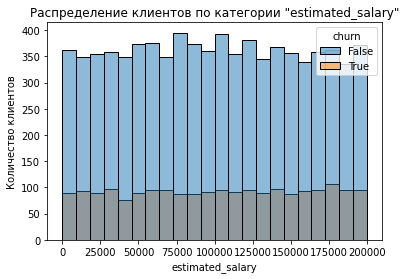

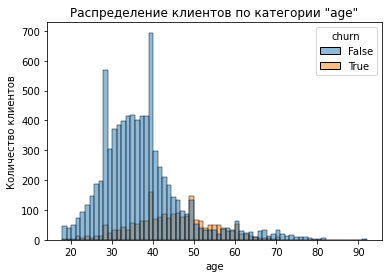

In [180]:
columns = ['balance', 'score', 'estimated_salary', 'age']
for column in columns:
    sns.histplot(x=column,  data=banks, hue='churn')
    plt.title(f'Распределение клиентов по категории "{column}"')
    plt.xlabel(column)
    plt.ylabel('Количество клиентов')
    plt.show() 

Рассмотрим распределение клиентов по категориям 'city', 'gender', 'objects', 'products', 'credit_card', 'loyalty'' в виде столбчатых диаграмм

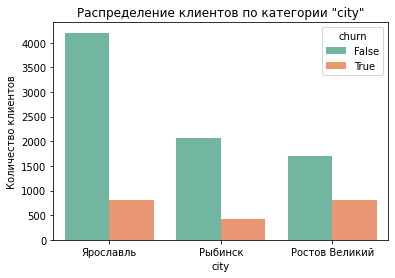

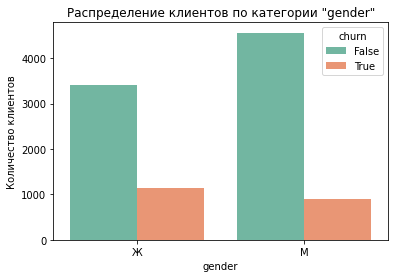

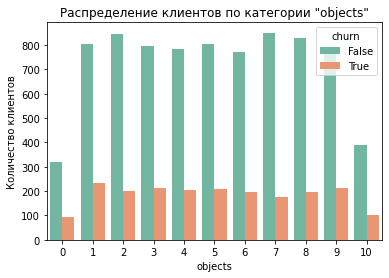

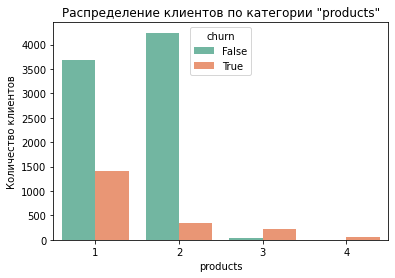

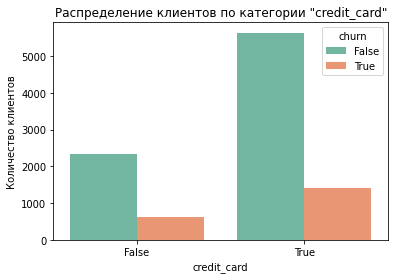

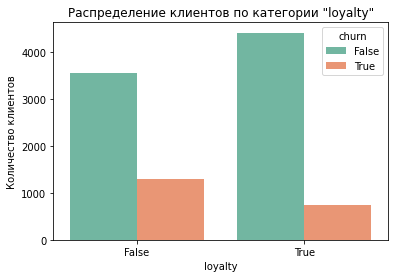

In [181]:
columns = ['city', 'gender', 'objects', 'products', 'credit_card', 'loyalty']
for column in columns:
    sns.countplot(x=column,  data=banks, palette = 'Set2', hue='churn')
    plt.title(f'Распределение клиентов по категории "{column}"')
    plt.xlabel(column)
    plt.ylabel('Количество клиентов')
    plt.show() 

Вывод: Исходя из графиков, можно сделать вывод, что больше всего клиентов в Ярославле, что вполне логично, тк это административный центр области. По половому признаку преобладают клиенты мужского пола. Также можно сказать, что большое количество клиентов имеют от 1 до 9 объектов в собственности, меньше всего клиентов, у которых нет объектов в собственности или более 9. По количеству используемых продуктов банка можно сказать, что большинство клиентов используют 1-2 продукта. Больше всего клиентов использующих 1 продукт. Большинство клиентов банка используют кредитную карту. Среди активных клиентов банка достаточно низкий процент ухода, среди неактивных клиентов процент ухода гораздо выше. Количество ушедших клиентов банка занимает около 2000.

### Матрица корреляций

Создадим бинарные столбцы для пола и городов для того, чтобы мы видели полную корреляцию данных

In [182]:
abc = pd.get_dummies (banks, columns=['gender','city'])
display(abc)

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
0,15677338,619,42,2,NaN,1,True,True,101348.88,True,1,0,0,0,1
1,15690047,608,41,1,83807.86,1,False,True,112542.58,False,1,0,0,1,0
2,15662040,502,42,8,159660.80,3,True,False,113931.57,True,1,0,0,0,1
3,15744090,699,39,1,NaN,2,False,False,93826.63,False,1,0,0,0,1
4,15780624,850,43,2,125510.82,1,True,True,79084.10,False,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,39,5,NaN,2,True,False,96270.64,False,0,1,0,0,1
9996,15612628,516,35,10,57369.61,1,True,True,101699.77,False,0,1,0,0,1
9997,15627268,709,36,7,NaN,1,False,True,42085.58,True,1,0,0,0,1
9998,15725091,772,42,3,75075.31,2,True,False,92888.52,True,0,1,1,0,0


Рассмотрим корреляцию всех признаков одной таблице

In [183]:
abc.corr()

,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,gender_Ж,gender_М,city_Ростов Великий,city_Рыбинск,city_Ярославль
score,1.000000,-0.003965,0.000842,-0.004744,0.012238,-0.005458,0.025651,-0.001384,-0.027094,0.002857,-0.002857,0.005538,0.004780,-0.008928
age,-0.003965,1.000000,-0.009997,-0.012822,-0.030680,-0.011721,0.085472,-0.007201,0.285323,0.027544,-0.027544,0.046897,-0.001685,-0.039208
objects,0.000842,-0.009997,1.000000,0.005827,0.013444,0.022583,-0.028362,0.007784,-0.014001,-0.014733,0.014733,-0.000567,0.003868,-0.002848
balance,-0.004744,-0.012822,0.005827,1.000000,-0.001027,0.006721,-0.020418,-0.001856,0.017208,-0.025742,0.025742,-0.002604,-0.000208,0.002759
products,0.012238,-0.030680,0.013444,-0.001027,1.000000,0.003183,0.009612,0.014204,-0.047820,0.021859,-0.021859,-0.010419,0.009039,0.001230
credit_card,-0.005458,-0.011721,0.022583,0.006721,0.003183,1.000000,-0.011866,-0.009933,-0.007138,-0.005766,0.005766,0.010577,-0.013480,0.002467
loyalty,0.025651,0.085472,-0.028362,-0.020418,0.009612,-0.011866,1.000000,-0.011421,-0.156128,-0.022544,0.022544,-0.020486,0.016732,0.003317
estimated_salary,-0.001384,-0.007201,0.007784,-0.001856,0.014204,-0.009933,-0.011421,1.000000,0.012097,0.008112,-0.008112,0.010297,-0.006482,-0.003332
churn,-0.027094,0.285323,-0.014001,0.017208,-0.047820,-0.007138,-0.156128,0.012097,1.000000,0.106512,-0.106512,0.173488,-0.052667,-0.104955
gender_Ж,0.002857,0.027544,-0.014733,-0.025742,0.021859,-0.005766,-0.022544,0.008112,0.106512,1.000000,-1.000000,0.024628,-0.016889,-0.006772


Построим матрицу корреляций 

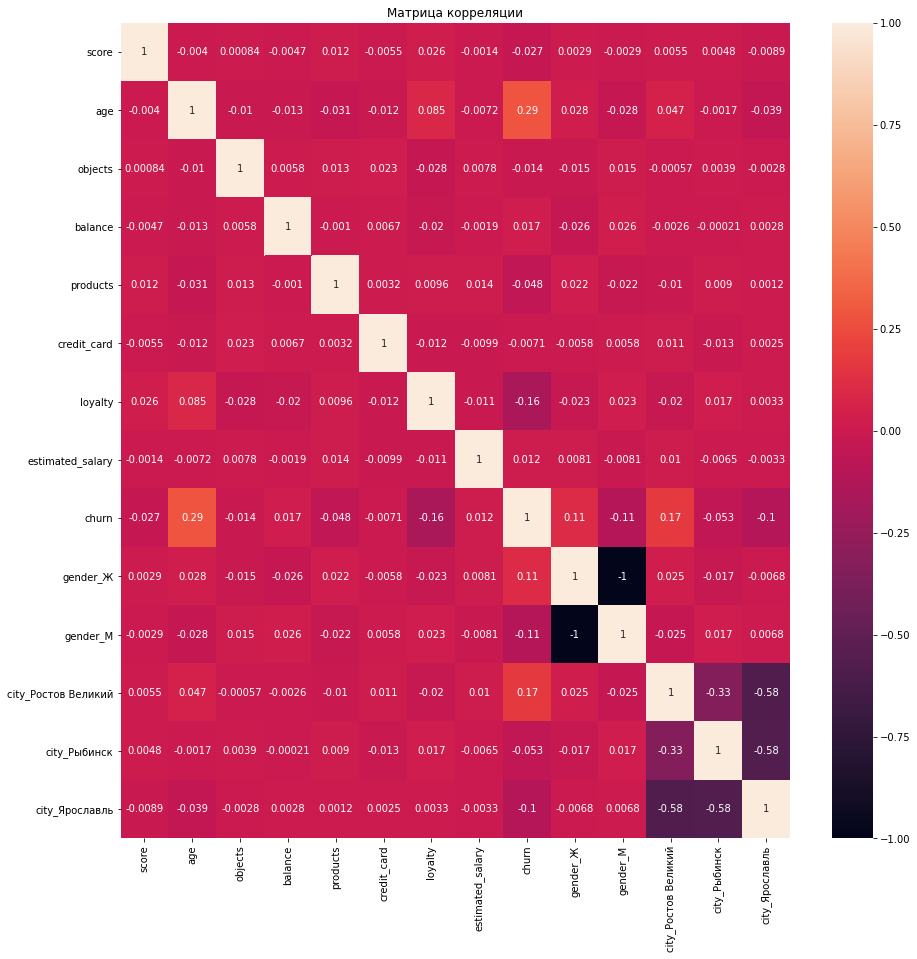

In [184]:
plt.figure(figsize = (15,15))
sns.heatmap(abc.corr(), annot=True)
plt.title('Матрица корреляции')
plt.show()

Вывод: исходя из матрицы корреляций можно сделать вывод, что взаимосвязь между признаками очень слабая. Самое высокое значение 0,3 - подтверждает отсутствие связи. 

## Сегментация пользователей

Добавим категорию определяющую уровень дохода клиента, это сможет нам дать более полную картинку об каждом сегменте.


In [185]:
banks['estimated_salary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: estimated_salary, dtype: float64

Опираясь на полученные выше значения, напишем функцию распределяющую клиентов по уровню дохода.

Категории дохода:
- Низкий доход: зарплата ниже 30 000 рублей
- Ниже среднего: зарплата от 50 000 рублей до 50 000 рублей
- Средний доход: зарплата от 50 000 рублей до 100 000 рублей
- Выше среднего: зарплата от 100 000 рублей до 150 000 рублей
- Высокий: зарплата выше 150 000 

In [186]:
#функция для разделения на категории по уровню дохода
def categorize_salary(salary):
    try:
        if salary >= 150000 :
            return 'Высокий'
        elif salary <= 30000:
            return 'Низкий' 
        elif salary > 30000 and salary <= 50000:
            return 'Ниже среднего'
        elif salary > 50000 and salary <= 100000:
            return 'Средний'
        return 'Выше среднего'        
    except:
        return 'нет категории'

Запишем категории доходов в отдельный столбец 'salary_categorize'

In [187]:
banks['salary_categorize'] = banks['estimated_salary'].apply(categorize_salary)

In [188]:
banks['salary_categorize'].value_counts()

Выше среднего    2555
Средний          2537
Высокий          2455
Низкий           1478
Ниже среднего     975
Name: salary_categorize, dtype: int64

Также разделим клиентов по возрастам

In [189]:
banks['age'].describe()

count    10000.000000
mean        38.921800
std         10.487806
min         18.000000
25%         32.000000
50%         37.000000
75%         44.000000
max         92.000000
Name: age, dtype: float64

Опираясь на полученные выше значения, напишем функцию распределяющую клиентов по возрастам.

Категории:

- Молодой: возраст от 18 до 25 лет
- Зрелый: возраст от 25 до 60 лет
- Пожилой: возраст от 60 лет

In [190]:
#функция для разделения на категории по возрасту
def categorize_age(age):
    try:
        if age >= 18 and age <= 25:
            return 'Молодой'
        elif age > 25 and age <= 60:
            return 'Зрелый' 
        return 'Пожилой'        
    except:
        return 'нет категории'

Создадим столбец с категориями по возрастам

In [191]:
banks['age_categorize'] = banks['age'].apply(categorize_age)

In [192]:
banks['age_categorize'].value_counts()

Зрелый     8925
Молодой     611
Пожилой     464
Name: age_categorize, dtype: int64

Несмотря на то, что категория 'Зрелый' получилась достаточно большой, разбивать ее на более мелкие категории нет большого смысла, тк важно посмотреть именно отток молодых и пенсионеров,количество испольемых ими продуктов, чтобы выявить возможные проблемы в социальной программе банка. Для того, чтобы выявить их для зрелых людей не хватает данных таких как: наличие детей, семейное положение и т.д. 

Категория по баллам кредитного скоринга

In [193]:
banks['score'].describe()

count    10000.000000
mean       650.528800
std         96.653299
min        350.000000
25%        584.000000
50%        652.000000
75%        718.000000
max        850.000000
Name: score, dtype: float64

In [194]:
#функция для разделения на категории по количеству баллов кредитного скоринга
def categorize_score(score):
    try:
        if score >= 350 and score <= 600:
            return 'Вероятность получения кредита мала'
        elif score > 600 and score <= 720:
            return 'Хорошие шансы на получение кредита' 
        return 'Вероятность отказа в кредите минимальна'        
    except:
        return 'нет категории'

In [195]:
banks['score_categorize'] = banks['score'].apply(categorize_score)

In [196]:
banks['score_categorize'].value_counts()

Хорошие шансы на получение кредита         4526
Вероятность получения кредита мала         3066
Вероятность отказа в кредите минимальна    2408
Name: score_categorize, dtype: int64

### Портрет клиента, использующего 1 продукт

In [197]:
df = banks.query('products == 1')
display(df)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,salary_categorize,age_categorize,score_categorize
0,15677338,619,Ярославль,Ж,42,2,NaN,1,True,True,101348.88,True,Выше среднего,Зрелый,Хорошие шансы на получение кредита
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,False,True,112542.58,False,Выше среднего,Зрелый,Хорошие шансы на получение кредита
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,True,True,79084.10,False,Средний,Зрелый,Вероятность отказа в кредите минимальна
9,15635125,684,Ярославль,М,27,2,134603.88,1,True,True,71725.73,False,Средний,Зрелый,Хорошие шансы на получение кредита
16,15780188,653,Ростов Великий,М,58,1,132602.88,1,True,False,5097.67,True,Низкий,Зрелый,Хорошие шансы на получение кредита
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,15699841,726,Рыбинск,М,36,2,NaN,1,True,False,195192.40,False,Высокий,Зрелый,Вероятность отказа в кредите минимальна
9993,15612002,644,Ярославль,М,28,7,155060.41,1,True,False,29179.52,False,Низкий,Зрелый,Хорошие шансы на получение кредита
9996,15612628,516,Ярославль,М,35,10,57369.61,1,True,True,101699.77,False,Выше среднего,Зрелый,Вероятность получения кредита мала
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,False,True,42085.58,True,Ниже среднего,Зрелый,Хорошие шансы на получение кредита


Всего 5084 клиентов которые пользуются 1 продуктом банка

Рассмотрим распределение клиентов, использующих 1 продукт, по признакам

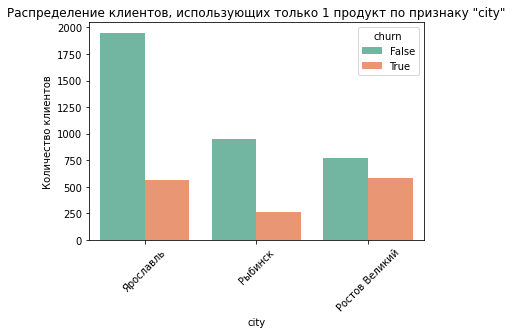

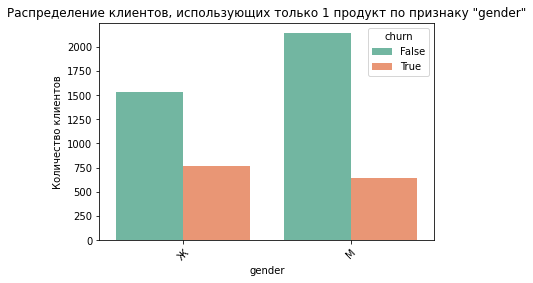

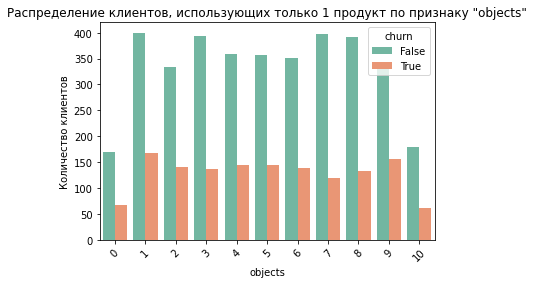

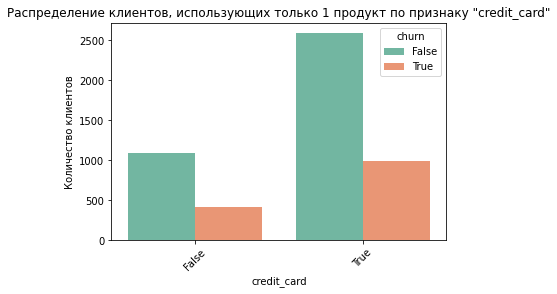

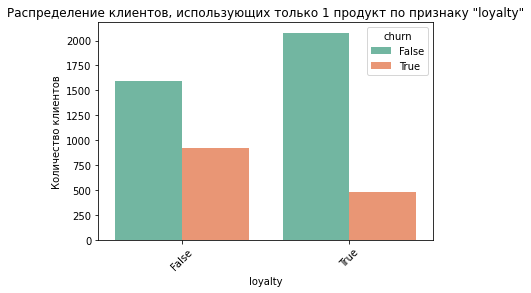

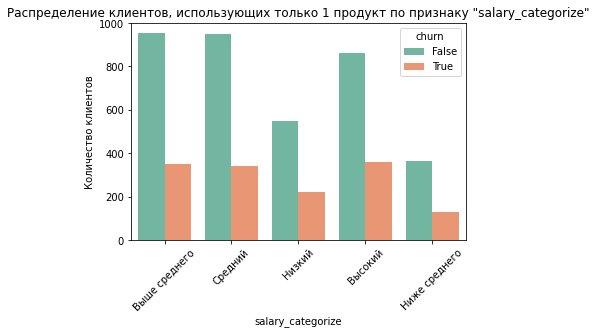

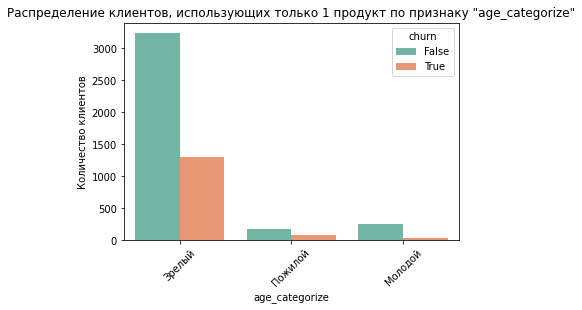

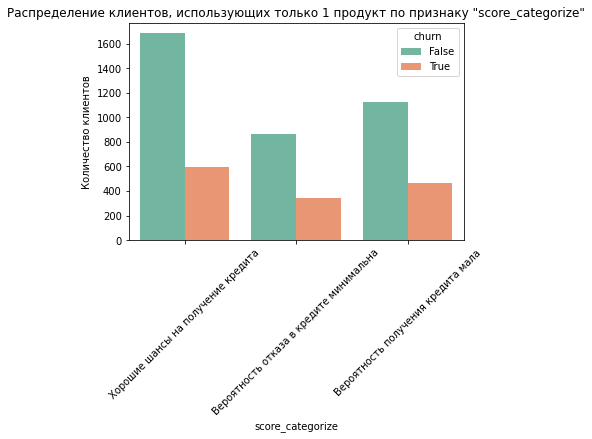

In [198]:
columns2 = ['city', 'gender', 'objects', 'credit_card', 'loyalty',  'salary_categorize', 'age_categorize', 'score_categorize']
for column in columns2:
        sns.countplot(x=column,  data=df, palette = 'Set2', hue='churn')
        plt.title(f'Распределение клиентов, использующих только 1 продукт по признаку "{column}"')
        plt.xlabel(column)
        plt.ylabel('Количество клиентов')
        plt.xticks(rotation=45)
        plt.show() 


In [199]:
print('Процент ушедших пользователей, использующих 1 продукт составляет:', round(len(df.query('churn == True')) * 100 / len(banks.query('products == 1'))),'%')


Процент ушедших пользователей, использующих 1 продукт составляет: 28 %


Вывод: Исходя из графиков, можно сделать вывод, что портрет клиента, который использует 1 продукт, можно представить как:

- преимущественно житель Ярославля
- преимущественно мужчина
- использует кредитную карту 

Взаимосвязи между количеством объектов в собственности как таковой нет. Процент ушедших пользователей составлят 28%. Можно заметить большой процент оттока среди неактивных пользователей. Наименьшее количество пользователей среди клиентов с низким и доходом ниже среднего. Наибольшее количество пользователей с хорошими шансами на получение кредита.

### Портрет клиента, использующего 2 продукта

In [200]:
data = banks.query('products == 2')
display(data)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,salary_categorize,age_categorize,score_categorize
3,15744090,699,Ярославль,Ж,39,1,NaN,2,False,False,93826.63,False,Средний,Зрелый,Хорошие шансы на получение кредита
5,15616748,645,Рыбинск,М,44,8,113755.78,2,True,False,149756.71,True,Выше среднего,Зрелый,Хорошие шансы на получение кредита
6,15635267,822,Ярославль,М,50,7,NaN,2,True,True,10062.80,False,Низкий,Зрелый,Вероятность отказа в кредите минимальна
8,15835101,501,Ярославль,М,44,4,142051.07,2,False,True,74940.50,False,Средний,Зрелый,Вероятность получения кредита мала
10,15810557,528,Ярославль,М,31,6,102016.72,2,False,False,80181.12,False,Средний,Зрелый,Вероятность получения кредита мала
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,15632065,775,Ярославль,М,30,4,NaN,2,True,False,49337.84,False,Ниже среднего,Зрелый,Вероятность отказа в кредите минимальна
9989,15648358,841,Рыбинск,М,28,4,NaN,2,True,True,179436.60,False,Высокий,Зрелый,Вероятность отказа в кредите минимальна
9994,15762030,800,Ярославль,Ж,29,2,NaN,2,False,False,167773.55,False,Высокий,Зрелый,Вероятность отказа в кредите минимальна
9995,15648965,771,Ярославль,М,39,5,NaN,2,True,False,96270.64,False,Средний,Зрелый,Вероятность отказа в кредите минимальна


Всего пользователей использующих 2 продукта - 4590.

Рассмотрим распределение клиентов, использующих 2 продукта, по признакам

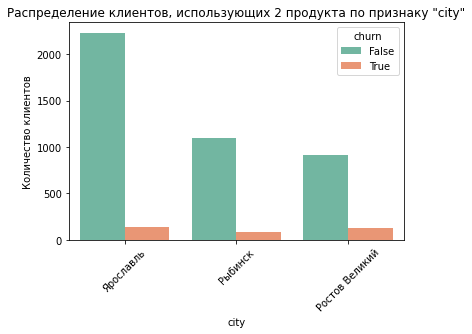

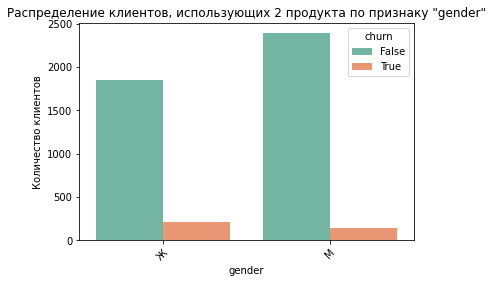

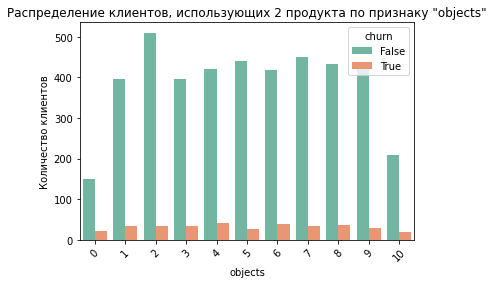

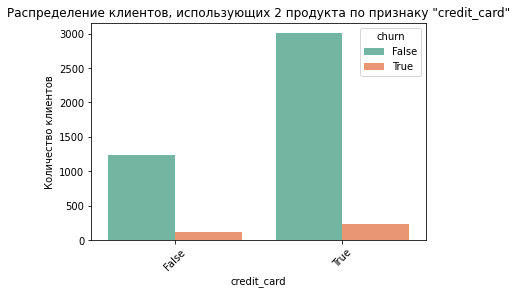

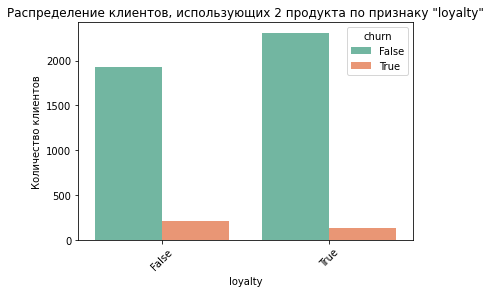

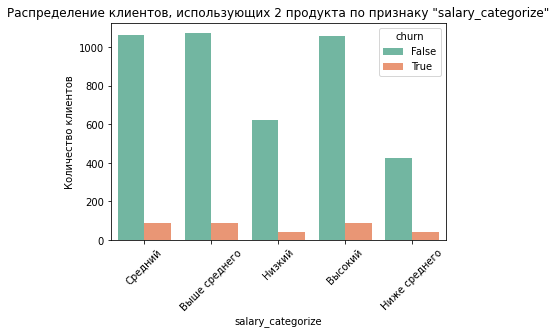

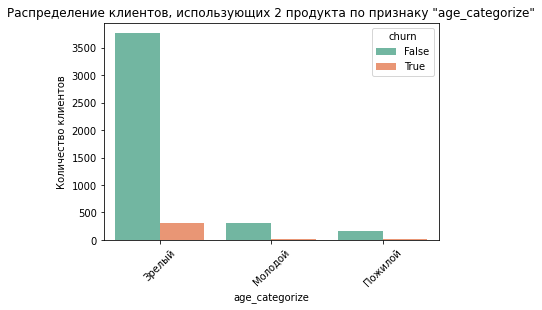

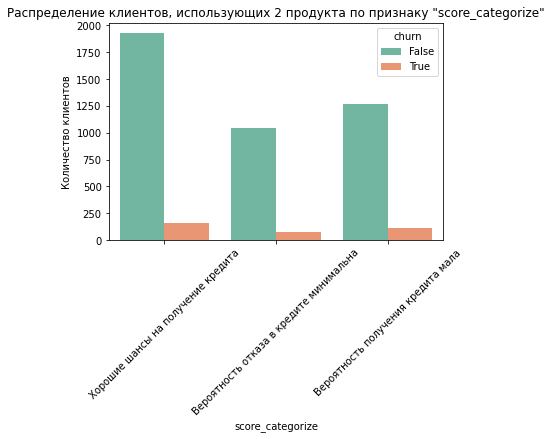

In [201]:
columns3 = ['city', 'gender', 'objects', 'credit_card', 'loyalty', 'salary_categorize', 'age_categorize', 'score_categorize']
for column in columns3:
    sns.countplot(x=column,  data=data, palette = 'Set2', hue='churn')
    plt.title(f'Распределение клиентов, использующих 2 продукта по признаку "{column}"')
    plt.xlabel(column)
    plt.ylabel('Количество клиентов')
    plt.xticks(rotation=45)
    plt.show() 

In [202]:
print('Процент ушедших пользователей, использующих 2 продукта составляет:', round(len(data.query('churn == True')) * 100 / len(banks.query('products == 2'))),'%')


Процент ушедших пользователей, использующих 2 продукта составляет: 8 %


Вывод: Можно выявить следующие общие черты для пользователей 2 продуктов:

- преимущественно мужчины
- пользующиеся кредитной картой

Как для активных, так и для неактивных клиентов банка процент оттока небольшой. Можно также заметить, что среди клиентов, которые используют 2 продукта процент ушедших пользователей составляет 8%, а для клиентов, использующих 1 продукт, это число составляет 28%. При том что количество пользователей 1 продукта выше пользователей 2 продуктов всего на 494 клиента, однако разница между уходящими 20%, это говорит о том, что нужно задуматься об обновлении системы удержания пользователей с 1 продуктом. Также заметен отток среди зрелых пользователей.



### Портрет клиента, использующего 3 продукта

In [203]:
three_products = banks.query('products == 3')
display(three_products)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,salary_categorize,age_categorize,score_categorize
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,True,False,113931.57,True,Выше среднего,Зрелый,Вероятность получения кредита мала
30,15632211,591,Рыбинск,Ж,39,3,NaN,3,True,False,140469.38,True,Выше среднего,Зрелый,Вероятность получения кредита мала
88,15665633,646,Ярославль,Ж,46,4,NaN,3,True,False,93251.42,True,Средний,Зрелый,Хорошие шансы на получение кредита
90,15800271,647,Рыбинск,Ж,44,5,NaN,3,True,True,174205.22,True,Высокий,Зрелый,Хорошие шансы на получение кредита
227,15719631,547,Ростов Великий,Ж,39,6,74596.15,3,True,True,85746.52,True,Средний,Зрелый,Вероятность получения кредита мала
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9737,15783933,710,Рыбинск,М,22,8,NaN,3,True,False,107292.91,False,Выше среднего,Молодой,Хорошие шансы на получение кредита
9747,15818497,610,Ростов Великий,Ж,69,5,86038.21,3,False,False,192743.06,True,Высокий,Пожилой,Хорошие шансы на получение кредита
9800,15683243,762,Рыбинск,Ж,35,3,119349.69,3,True,True,47114.18,True,Ниже среднего,Зрелый,Вероятность отказа в кредите минимальна
9877,15614918,505,Ростов Великий,Ж,33,3,106506.77,3,True,False,45445.78,True,Ниже среднего,Зрелый,Вероятность получения кредита мала


Пользователей использующих 3 продукта значительно меньше чем пользователей 1 и 2 продуктов. Их всего - 266

Рассмотрим распределение клиентов, использующих 3 продукта, по признакам

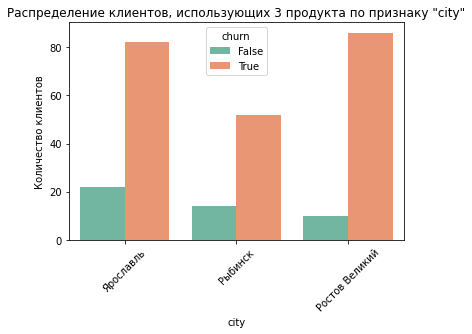

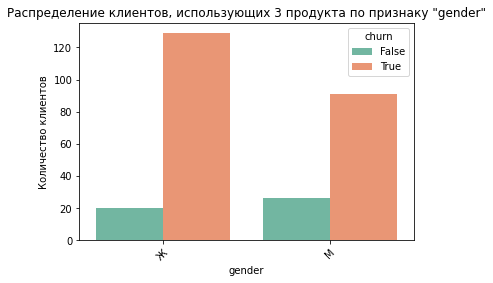

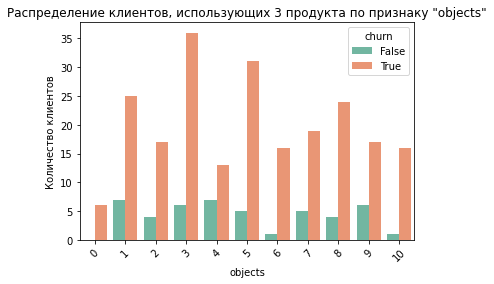

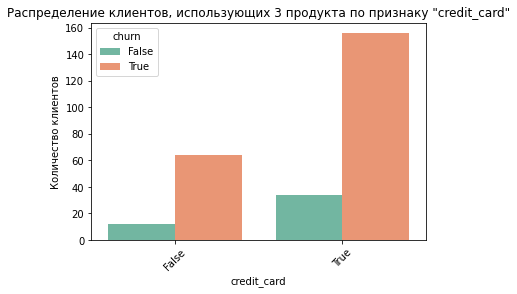

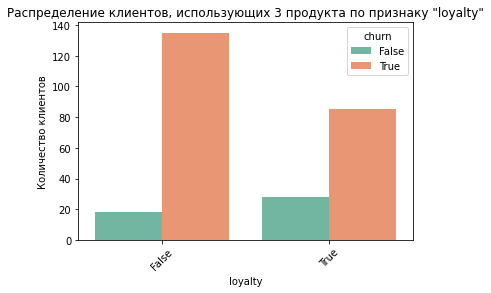

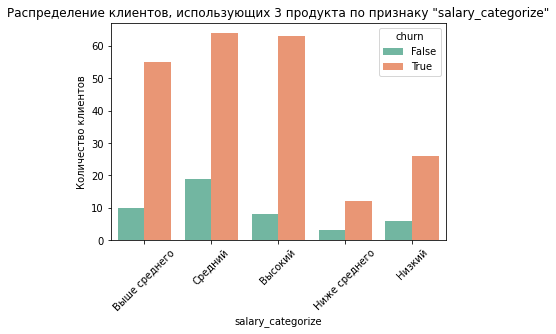

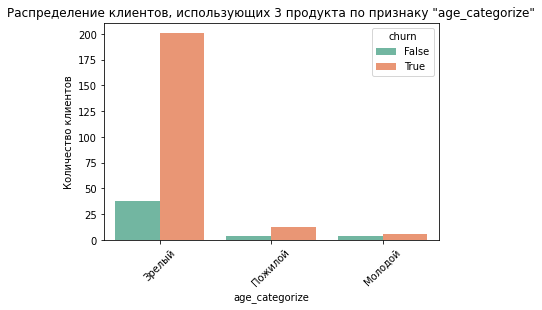

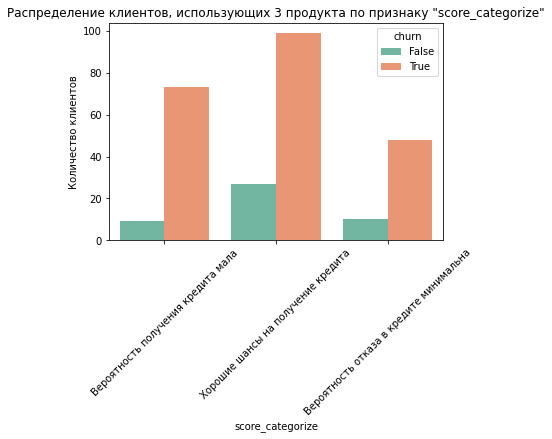

In [204]:
columns4 = ['city', 'gender', 'objects', 'credit_card', 'loyalty', 'salary_categorize', 'age_categorize', 'score_categorize']
for column in columns4:
    sns.countplot(x=column,  data=three_products, palette = 'Set2', hue='churn')
    plt.title(f'Распределение клиентов, использующих 3 продукта по признаку "{column}"')
    plt.xlabel(column)
    plt.ylabel('Количество клиентов')
    plt.xticks(rotation=45)
    plt.show() 

In [205]:
print('Процент ушедших пользователей, использующих 3 продукта составляет:', round(len(three_products.query('churn == True')) * 100 / len(banks.query('products == 3'))),'%')


Процент ушедших пользователей, использующих 3 продукта составляет: 83 %


Вывод: Портрет пользователя, использующего 3 продукта можно представить следующим:
- преимущественно женщина
- среди объектов в собственности явно лидируют 3 объекта и 5
- пользователь кредитной карты

Можно заметить также очень высокий процент ухода таких пользователей. Он составляет - 83%. Можно заметить, что если для пользователей, использующих 1-2 продукта, процент уходящих пользователей для зрелых людей небольшой, то здесь он значительно превышает количество оставшихся. Аналогично для категорий пожилой, молодой. 

Также можно заметить большой отток как активных, так и неактивных пользователей. Преимущественно уходят пользователи с хорошими шансами на получение кредита.

### Портрет клиента, использующего 4 продукта

In [206]:
four_products = banks.query('products == 4')
display(four_products)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,salary_categorize,age_categorize,score_categorize
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,True,False,119346.88,True,Выше среднего,Зрелый,Вероятность получения кредита мала
70,15746529,738,Ростов Великий,М,58,2,133745.44,4,True,False,28373.86,True,Низкий,Зрелый,Вероятность отказа в кредите минимальна
1254,15653119,628,Ярославль,Ж,46,1,46870.43,4,True,False,31272.14,True,Ниже среднего,Зрелый,Хорошие шансы на получение кредита
1469,15713110,819,Ростов Великий,Ж,49,1,120656.86,4,False,False,166164.30,True,Высокий,Зрелый,Вероятность отказа в кредите минимальна
1488,15668560,596,Рыбинск,М,30,6,121345.88,4,True,False,41921.75,True,Ниже среднего,Зрелый,Вероятность получения кредита мала
1701,15648015,792,Ярославль,М,50,9,NaN,4,True,True,194700.81,True,Высокий,Зрелый,Вероятность отказа в кредите минимальна
1876,15707490,640,Ростов Великий,М,39,9,131607.28,4,False,True,6981.43,True,Низкий,Зрелый,Хорошие шансы на получение кредита
2124,15646587,704,Ярославль,М,32,7,127785.17,4,False,False,184464.70,True,Высокий,Зрелый,Хорошие шансы на получение кредита
2196,15834436,773,Ростов Великий,М,47,2,118079.47,4,True,True,143007.49,True,Выше среднего,Зрелый,Вероятность отказа в кредите минимальна
2285,15826351,630,Ростов Великий,М,50,3,129370.91,4,True,True,47775.34,True,Ниже среднего,Зрелый,Хорошие шансы на получение кредита


In [207]:
print('Количество клиентов, использующих 4 продукта:', len(four_products))

Количество клиентов, использующих 4 продукта: 60


Рассмотрим распределение клиентов, использующих 4 продукта, по признакам

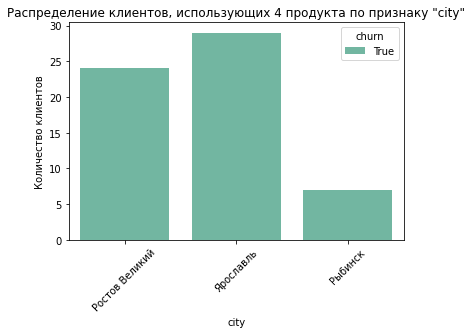

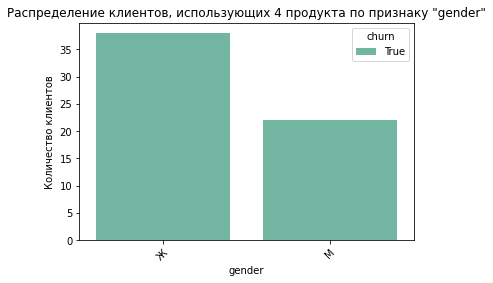

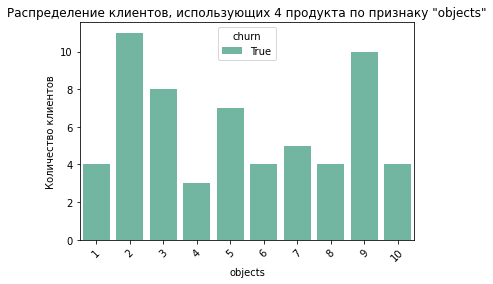

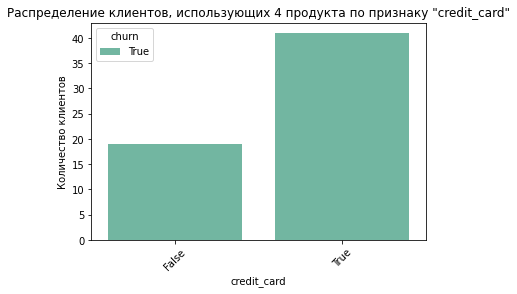

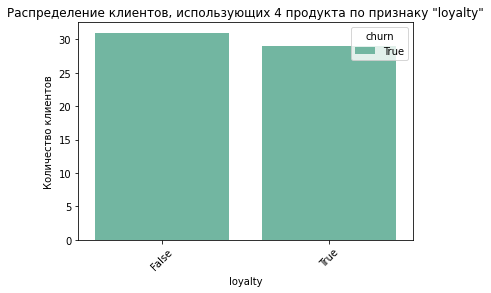

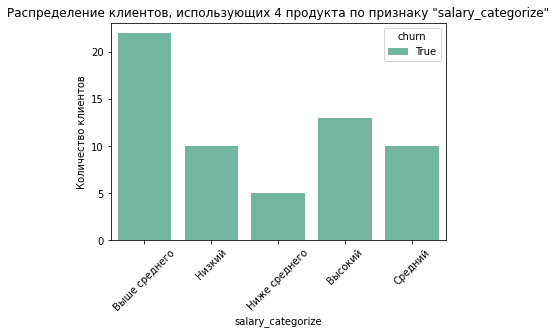

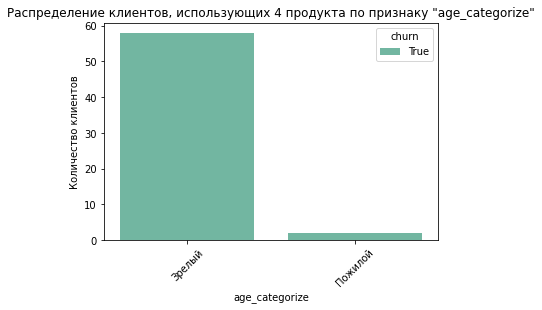

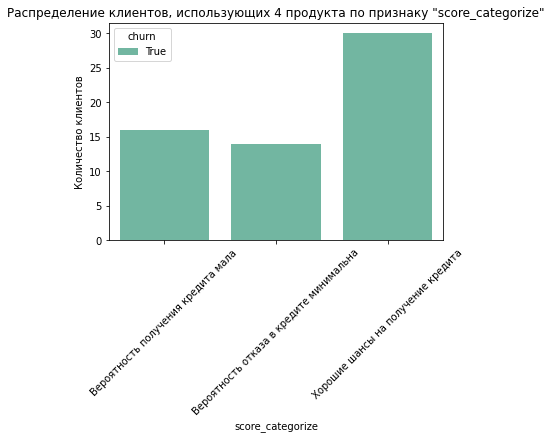

In [208]:
columns4 = ['city', 'gender', 'objects', 'credit_card', 'loyalty', 'salary_categorize', 'age_categorize', 'score_categorize']
for column in columns4:
    sns.countplot(x=column,  data=four_products, palette = 'Set2', hue='churn')
    plt.title(f'Распределение клиентов, использующих 4 продукта по признаку "{column}"')
    plt.xlabel(column)
    plt.ylabel('Количество клиентов')
    plt.xticks(rotation=45)
    plt.show() 

Вывод: Портрет клиента, который использует 4 продукта:
Первое что бросается в глаза - все клиенты использующие 4 продукта перестали пользоваться услугами банка. Количество таких пользователей 60 человек, что значительно меньше чем пользователей 1-3 продуктов. 
 - преимущественно женщины
 - использующие кредитные карты
 
 Можно также заметить, что молодые пользователи не используют 4 продукта, также клиенты с высоким и средним уровнем дохода не так часто используют 4 продукта. И все пользователи использующие 4 продукта - перестали быть клиентами банка. Аналогично для пользователей 3 продуктов, наибольшой отток происходит среди пользователей с хорошими шансами на получение кредита.

Однако можно сказать, что количество пользователей 3 продуктов( 266) и 4 продуктов (60) является очень небольшим от общего числа( 10000), поэтому анализ их поведения малоинформативен, но все же дает почву для размышлений.

## Статистический анализ данных

### Средняя зарплата клиентов, использующих один продукт, не отличается от средней зарплаты клиентов использующих 2 продукта.

Сравним зарплаты между клиентами, использующими 1 продукт, и пользователями, использующими 2 продукта.

Рассмотрим распределение зарплаты клиентов, использующих 1-2 продукта

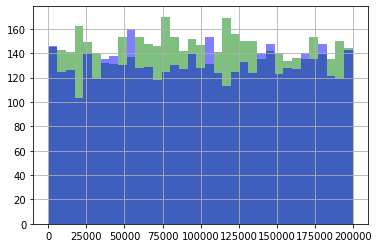

In [209]:
df['estimated_salary'].hist(bins=35, alpha=0.5, color='green')
data['estimated_salary'].hist(bins=35, alpha=0.5, color='blue');

 Будем проверять гипотезу о равенстве среднего двух генеральных совокупностей с помощью t-критерия

Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза: Средняя зарплата клиентов, использующих один продукт, не отличается от средней зарплаты клиентов использующих 2 продукта.

Альтернативная гипотеза: Средняя зарплата клиентов, использующих один продукт, отличается от средней зарплаты клиентов использующих 2 продукта.

alpha: 0.05

In [210]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(
    df['estimated_salary'], 
    data['estimated_salary'], equal_var=False)
#alpha = задайте значение уровня значимости
alpha = 0.05

# вывод значения p-value на экран 
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

0.4106493940071987
Не получилось отвергнуть нулевую гипотезу


Вывод: исходя из результатов, можно сделать вывод, что средняя зарплата клиентов, использующих один продукт, не отличается от средней зарплаты клиентов использующих 2 продукта.

### Доля ушедших пользователей, использующих кредитную карту, не отличается от доли ушедших пользователей, не использующих кредитную карту.

Выделим ушедших пользователей, использующих кредитную карту

In [211]:
banks.query('churn == True and credit_card== True')


,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,salary_categorize,age_categorize,score_categorize
0,15677338,619,Ярославль,Ж,42,2,NaN,1,True,True,101348.88,True,Выше среднего,Зрелый,Хорошие шансы на получение кредита
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,True,False,113931.57,True,Выше среднего,Зрелый,Вероятность получения кредита мала
5,15616748,645,Рыбинск,М,44,8,113755.78,2,True,False,149756.71,True,Выше среднего,Зрелый,Хорошие шансы на получение кредита
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,True,False,119346.88,True,Выше среднего,Зрелый,Вероятность получения кредита мала
16,15780188,653,Ростов Великий,М,58,1,132602.88,1,True,False,5097.67,True,Низкий,Зрелый,Хорошие шансы на получение кредита
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,15709031,610,Ростов Великий,М,50,1,113957.01,2,True,False,196526.55,True,Высокий,Зрелый,Хорошие шансы на получение кредита
9981,15715490,498,Ростов Великий,М,42,3,152039.70,1,True,True,53445.17,True,Средний,Зрелый,Вероятность получения кредита мала
9982,15810899,655,Ростов Великий,Ж,46,7,137145.12,1,True,False,115146.40,True,Выше среднего,Зрелый,Хорошие шансы на получение кредита
9991,15812695,597,Ярославль,Ж,53,4,88381.21,1,True,False,69384.71,True,Средний,Зрелый,Вероятность получения кредита мала


Выделим ушедших пользователей, не использующих кредитную карту

In [212]:
banks.query('churn == True and credit_card == False')


,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,salary_categorize,age_categorize,score_categorize
41,15780884,465,Ярославль,Ж,51,8,122522.32,1,False,False,181297.65,True,Высокий,Зрелый,Вероятность получения кредита мала
43,15797932,834,Ярославль,Ж,49,2,131394.56,1,False,False,194365.76,True,Высокий,Зрелый,Вероятность отказа в кредите минимальна
53,15745034,655,Ростов Великий,М,41,8,125561.97,1,False,False,164040.94,True,Высокий,Зрелый,Хорошие шансы на получение кредита
114,15652354,721,Ростов Великий,М,28,9,154475.54,2,False,True,101300.94,True,Выше среднего,Зрелый,Вероятность отказа в кредите минимальна
126,15713873,549,Ярославль,Ж,52,1,NaN,1,False,True,8636.05,True,Низкий,Зрелый,Вероятность получения кредита мала
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,15729710,751,Ярославль,Ж,48,4,NaN,1,False,True,30165.06,True,Ниже среднего,Зрелый,Вероятность отказа в кредите минимальна
9917,15798467,635,Ростов Великий,М,53,8,117005.55,1,False,True,123646.57,True,Выше среднего,Зрелый,Хорошие шансы на получение кредита
9920,15715756,678,Ярославль,Ж,49,3,204510.94,1,False,True,738.88,True,Низкий,Зрелый,Хорошие шансы на получение кредита
9962,15637348,702,Рыбинск,М,44,9,NaN,1,False,False,59207.41,True,Средний,Зрелый,Хорошие шансы на получение кредита


Сформулируем нулевую и альтернативную гипотезы.

Нулевая гипотеза: Доля ушедших пользователей, использующих кредитную карту, не отличается от доли ушедших пользователей, не использующих кредитную карту.

Альтернативная гипотеза: Доля ушедших пользователей, использующих кредитную карту, отличается от доли ушедших пользователей, не использующих кредитную карту.

alpha: 0.05

In [213]:
alpha = .05 # критический уровень статистической значимости

credit = banks.query('credit_card == True')['credit_card'].count()
nocredit = banks.query('credit_card == False')['credit_card'].count()
churn_cr = banks.query('churn == True and credit_card == True')['credit_card'].count()
nochurn_cr = banks.query('churn == False and credit_card == True')['credit_card'].count()

# первая группа:
p1 = churn_cr/credit

# вторая группа:
p2 = nochurn_cr/nocredit

# комбинированный датасет:
p_combined = (churn_cr + nochurn_cr) / (credit + nocredit)

# разница пропорций в датасетах
difference = p1 - p2
# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/credit + 1/nocredit))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 
p_value = (1 - distr.cdf(abs(z_value))) * 2


if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
    )

Отвергаем нулевую гипотезу: между долями есть значимая разница


Вывод: Поскольку между долями есть значительная разница, то мы отвергаем нулевую гипотезу.Значит,что доля ушедших пользователей, использующих кредитную карту, отличается от доли ушедших пользователей, не использующих кредитную карту.

## Выводы и рекомендации

Вывод: В ходе работы над проектом была проведена сегментация пользователей по количеству используемых ими продуктов. Первым этапом работы была предобработка данных. Удалось выяснить, что явных дубликатов в данных нет. Все столбцы были приведены к нижнему регистру, названия столбцов user_id и credit_card были изменены. Для столбцов hurn,credit_card и loyalty тип данных был изменен на bool, для столбца user_id на object. Было обнаружено большое количество пропусков в столбце balance, однако они занимают слишком большой процент от общего числа данных для того, чтобы их удалять. Поэтому принято решение оставить их. Можно заметить, что огромное количество пропусков преобладает для клиентов, использующих 2 продукта, а также использующих кредитную карту. Также 86% пропусков в балансе составляют оставшиеся клиенты, поэтому пропуски нельзя связать с уходом клиентов и закрытием счетов. Возможно, пользователи имеют 2 продукта: дебетовая и кредитная карта. Из-за процентов или несвоевременного закрытия кредитной карты общий баланс счета становится отрицательным, поэтому вместо баланса появляются пропуски. Поскольку клиентов с балансом меньше 0 не удалось найти в датасете, то скорее всего причина именно в этом.  Была проведена проверка на аномалии: Для баланса на карте аномальными значениями можно назвать значения выше 220000 рублей,также меньше 380 баллов кредитного скоринга являются скорее аномальными значениями.

Следующим этапом работы над проектом был исследовательский анализ данных. Удалось выяснить общеее распределение клиентов по признакам. Больше всего клиентов в Ярославле, что вполне логично, тк это административный центр области. По половому признаку преобладают клиенты мужского пола. Также можно сказать, что большое количество клиентов имеют от 1 до 9 объектов в собственности, меньше всего клиентов, у которых нет объектов в собственности или более 9. По количеству используемых продуктов банка можно сказать, что большинство клиентов используют 1-2 продукта. Больше всего клиентов использующих 1 продукт. Большинство клиентов банка используют кредитную карту. Среди активных клиентов банка достаточно низкий процент ухода, среди неактивных клиентов процент ухода гораздо выше. Количество ушедших клиентов банка занимает около 2000. Была построена матрица корреляций, однако  взаимосвязь между признаками очень слабая. Самое высокое значение 0,3 - подтверждает отсутствие связи.

Была проведена сегментация пользователей. Перед этим данные были разделены на категории по уровню дохода, по возрасту, по баллам кредитного скоринга. Эти показатели могут дать более ясный портрет пользователя и возможно прояснить причины оттока. Был рассмотрен портрет клиента, использующего 1 продукт. Таким образом, это мужчина, преимущественно житель Ярославля, который использует кредитную карту. Взаимосвязи между количеством объектов в собственности как таковой нет. Процент ушедших пользователей составлят 28%. Можно заметить большой процент оттока среди неактивных пользователей. Наименьшее количество пользователей среди клиентов с низким и доходом ниже среднего. Наибольшее количество пользователей с хорошими шансами на получение кредита. 

Был также составлен портрет клиента, использующего 2 продукта.Это также мужчина, использующий кредитную карту. Как для активных, так и для неактивных клиентов банка процент оттока небольшой. Можно также заметить, что среди клиентов, которые используют 2 продукта процент ушедших пользователей составляет 8%, а для клиентов, использующих 1 продукт, это число составляет 28%. При том что количество пользователей 1 продукта выше пользователей 2 продуктов всего на 494 клиента, однако разница между уходящими 20%, это говорит о том, что нужно задуматься об обновлении системы удержания пользователей с 1 продуктом. Также заметен отток среди зрелых пользователей.

Портрет пользователя, использующего 3 продукта отличается от портретов пользователей 1-2 продуктов: преимущественно женщина, среди объектов в собственности явно лидируют 3 объекта и 5, пользователь кредитной карты. Можно заметить также очень высокий процент ухода таких пользователей. Он составляет - 83%. Можно заметить, что если для пользователей, использующих 1-2 продукта, процент уходящих пользователей для зрелых людей небольшой, то здесь он значительно превышает количество оставшихся. Аналогично для категорий пожилой, молодой. Также можно заметить большой отток как активных, так и неактивных пользователей. Преимущественно уходят пользователи с хорошими шансами на получение кредита.

Портрет клиента, который использует 4 продукта: Первое что бросается в глаза - все клиенты использующие 4 продукта перестали пользоваться услугами банка. Количество таких пользователей 60 человек, что значительно меньше чем пользователей 1-3 продуктов.
Это преимущественно женщины, использующие кредитные карты. Можно также заметить, что молодые пользователи не используют 4 продукта, также клиенты с высоким и средним уровнем дохода не так часто используют 4 продукта. И все пользователи использующие 4 продукта - перестали быть клиентами банка. Аналогично для пользователей 3 продуктов, наибольшой отток происходит среди пользователей с хорошими шансами на получение кредита.

Однако можно сказать, что количество пользователей 3 продуктов( 266) и 4 продуктов (60) является очень небольшим от общего числа( 10000), поэтому анализ их поведения малоинформативен, но все же дает почву для размышлений.

Последним этапом работы над проектом был статистический анализ данных, в ходе которого были выдвинуты 2 гипотезы. 1 гипотеза: Средняя зарплата клиентов, использующих один продукт, не отличается от средней зарплаты клиентов использующих 2 продукта. Нулевую гипотезу не удалось отвергнуть. 2 гипотеза: Доля ушедших пользователей, использующих кредитную карту, не отличается от доли ушедших пользователей, не использующих кредитную карту. Поскольку между долями есть значительная разница, то мы отвергаем нулевую гипотезу.Значит,что доля ушедших пользователей, использующих кредитную карту, отличается от доли ушедших пользователей, не использующих кредитную карту.


Рекомендации:


- Первое на что хочется обратить внимание - отток пользователей с хорошими шансами на кредит. Для всех сегметов у этой категории самый высокий отток. Из чего можно сделать предположение об невыгодной системе кредитования, возможно, стоит рассмотреть разработку различных льготных программ для выдачи кредита. 
- Можно заметить, что молодые люди не очень охотно пользуются услугами банка. Чтобы привлечь молодое поколение, можно выпустить молодежную карту с низкой ценой обслуживания. Или же попробовать сделать стипендиальную карту. 
- Количество клиентов пожилого возраста тоже является достаточно низким. Также можно попробовать оформить карту, с льготными условиями, например, низкая цена за обслуживание карты для пенсионеров. 